In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
import mpl_toolkits.mplot3d.art3d as art3d


In [45]:
# source: https://www.dimensions.com/element/basketball-backboards
# source: https://www.dimensions.com/element/basketball-court
# source: https://www.dimensions.com/element/basketball-rims-nets
 
BACKBOARD_WIDTH, BACKBOARD_HEIGHT = 1.8, 1.22     ## in meters
BASKET_DIAMETER, BASKET_HEIGHT    = 0.4572, 3.05  ## in meters
COURT_WIDTH, COURT_LENGTH         = 15.0, 28.0    ## in meters
BACKBOARD_BASKET_DISTANCE         = 0.151         ## in meters
BASKET_RING_THICKNESS             = 0.02          ## in meters
COURT_HEIGHT                      = 7.0           ## in meters
BACKBOARD_ZMIN                    = BASKET_HEIGHT ## Remember to account for ball
BACKBOARD_ZMAX                    = BASKET_HEIGHT+(1.219-0.305)
BACKBOARD_X                       = COURT_WIDTH/2  ## center of backboard
BACKBOARD_XMIN                    = COURT_WIDTH/2-BACKBOARD_WIDTH/2
BACKBOARD_XMAX                    = COURT_WIDTH/2+BACKBOARD_WIDTH/2
BACKBOARD_Y                       = COURT_LENGTH/2
BACKBOARD_hanger                  = 0.151
BASKET_Y                          = BACKBOARD_Y - (BASKET_DIAMETER/2+BACKBOARD_hanger)
BASKET_X                          = BACKBOARD_X

def random_starting_point():
    random_y = np.random.uniform(0,COURT_LENGTH/2-(BASKET_DIAMETER/2+0.151),size=1)
    random_x = np.random.uniform(0,COURT_WIDTH,size=1)
    random_z = np.random.uniform(0.35*BASKET_HEIGHT,BASKET_HEIGHT*1.7,size=1)
    return np.array([random_x,random_y,random_z])

def random_backboard_xy():
    BB_x = np.random.uniform(BACKBOARD_XMIN,BACKBOARD_XMAX,size=1)[0]
    BB_y = BACKBOARD_Y
    return BB_x, BB_y

def horizontal_dist_2_backboard(x_starting_point,y_starting_point,x_backboard,y_backboard):
    return np.sqrt((x_backboard-x_starting_point)**2+(y_backboard-y_starting_point)**2)
    
def random_angle(z_starting_point,horizontal_dist,zmax):
    min_angle = 1.000001*np.abs(np.arctan((z_starting_point+zmax)/(horizontal_dist)))
    #return np.random.uniform(min_angle,np.pi/2*0.9999999,size=1)
    return min_angle

def random_speed(angle,horizontal_dist,z_starting_point,zmax):
    g = 9.82
    min_speed = np.sqrt((g*(horizontal_dist)**2)/(2*((z_starting_point-zmin)+(horizontal_dist)*np.tan(angle))*np.cos(angle)**2))
    assert min_speed > 0, "Zero or negative speed"
    max_speed = np.sqrt((g*(horizontal_dist)**2)/(2*((z_starting_point-zmax)+(horizontal_dist)*np.tan(angle))*np.cos(angle)**2))
    assert max_speed > 0, "Zero or negative speed"
    return np.random.uniform(min_speed,max_speed,size=1)

def time_2_basket(v0,horizontal_dist,z_angle):
    return (horizontal_dist)/(v0*np.cos(z_angle))

def xy_angle(x_starting_point,y_starting_point,x_backboard,y_backboard):
    return np.arcsin((y_backboard-y_starting_point)/np.sqrt((x_backboard-x_starting_point)**2+(y_backboard-y_starting_point)**2))

def ball_path_3d(time_2_backboard,xy_angle,z_angle,x_starting_point,y_starting_point,z_starting_point,x_backboard,v0,rot_angle):
    g   = 9.82
    factor = 1.8
    base_nr_frames = 100
    ts1 = np.linspace(0,time_2_backboard*factor,int(base_nr_frames*factor))
    ts2 = np.linspace(0,time_2_backboard,base_nr_frames)
    ts3 = np.linspace(0,time_2_backboard*(factor-1),int(base_nr_frames*factor)-base_nr_frames)
    xs, ys, zs = [], [], []
    v_xy = v0*np.cos(z_angle)   ## Projection to xy plane
    vx = v_xy*np.cos(xy_angle)  ## component of projection in x dir
    vy = v_xy*np.sin(xy_angle)  ## component of projection in y dir
    if x_starting_point > x_backboard:
        vx*=-1
    for t in ts1:
        zs.append(v0*np.sin(z_angle)*t-g/2*t**2+z_starting_point)
    for t in ts2:
        xs.append(vx*t+x_starting_point)
        ys.append(vy*t+y_starting_point)
    new_y_starting_point = ys[-1]
    new_x_starting_point = xs[-1]
    vy *= -1
    v_vec = np.array([vx[0],vy[0]]).reshape((2,1))
    v_vec = rotate_vector(np.array([vx[0],vy[0]]),rot_angle)
    for t in ts3:
        xs.append(v_vec[0]*t+new_x_starting_point)
        ys.append(v_vec[1]*t+new_y_starting_point)
    return np.array(xs), np.array(ys), np.array(zs)

def calculated_z_rotation(X_BB,Y_BB,X_BC,Y_BC,X_SP,Y_SP):
    "BB = Backboard, BC = Center of basket, SP = Starting point"
    theta_i = np.pi/2-np.arcsin((Y_BB-Y_SP)/(np.sqrt((Y_BB-Y_SP)**2+(X_BB-X_SP)**2)))
    theta_c = np.pi/2-np.arcsin((Y_BB-Y_BC)/(np.sqrt((Y_BB-Y_BC)**2+(X_BB-X_BC)**2)))
    result = theta_c-theta_i
    print(f'Theta_i:{np.rad2deg(theta_i)}')
    print(f'Theta_c:{np.rad2deg(theta_c)}')
    if X_SP < X_BB and X_BB > BASKET_X:
        print("Case 1")
        result += 2*theta_i
        result *= -1
    if X_SP > X_BB and X_BB < BASKET_X:
        print("Case 2")
        result += 2*theta_i
    if X_SP > BASKET_X and X_BB > BASKET_X:
        print("Case 3")
        result*=-1
    if X_SP < BASKET_X and X_BB < BASKET_X:
        print("Case 4")
    return result

def rotate_backboard(angle,x,point):
    "Rotates backboard on z-axis at point = point"
    # Assuring that backboard keeps correct lengtj
    x[:,0] = np.array([point[0],point[0]])-np.cos(angle)*BACKBOARD_WIDTH/2
    x[:,1] = np.array([point[0],point[0]])+np.cos(angle)*BACKBOARD_WIDTH/2
    # Rotating
    y_rot = np.tan(angle)*x+BACKBOARD_Y
    # Shifting in y direction
    y_rot = y_rot - np.tan(angle)*point[0]
    return x,y_rot

def rotate_vector(vector,angle):
    rotation_matrix = np.array([[np.cos(angle),-np.sin(angle)],
                                [np.sin(angle), np.cos(angle)]])
    rotated_vector = rotation_matrix @ vector
    return rotated_vector


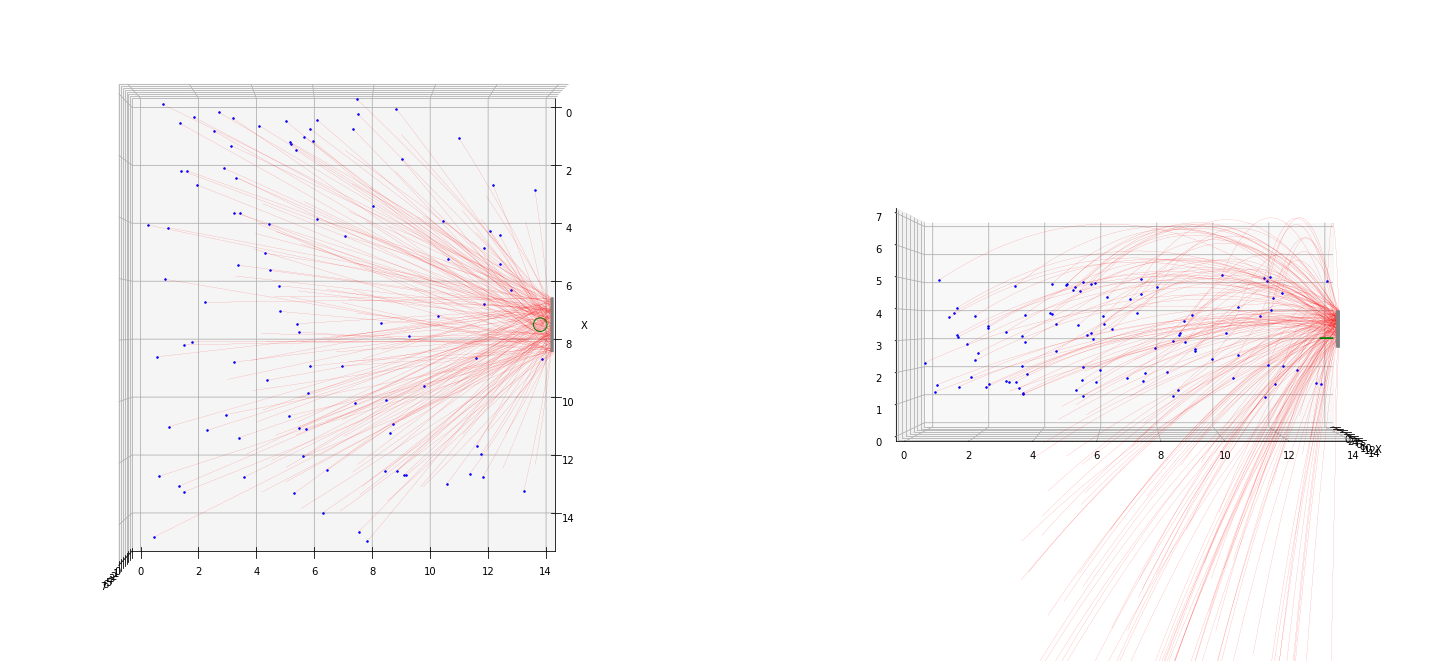

In [46]:
### Taking 10 random shots:

nr_shots = 100

xrndss, yrndss, zrndss = [], [], []
starting_points = []
for i in range(nr_shots):
    x_starting_point,y_starting_point,z_starting_point = random_starting_point()
    ## Approximate z range of basket backboard
    zmin, zmax = BACKBOARD_ZMIN, BACKBOARD_ZMAX
    ## Center location of basket backboard
    Basket_x, Basket_y = random_backboard_xy()
    ## Angle between direction in xy plane and x axis
    xy_theta = xy_angle(x_starting_point,y_starting_point,Basket_x,Basket_y)
    ## horizonal dist (in xy plane) from random point to backboard
    horizontal_dist = horizontal_dist_2_backboard(x_starting_point,y_starting_point,Basket_x,Basket_y)
    ## Random vertical angle
    z_theta  = random_angle(z_starting_point,horizontal_dist,zmax)
    ## Random speed  ( i.e.: ||v|| )
    v0rand = random_speed(z_theta,horizontal_dist,z_starting_point,zmax)
    ## Time to basket
    t = time_2_basket(v0rand,horizontal_dist,z_theta)
    ## Calculating parametric coords of path 
    xrnds, yrnds, zrnds = ball_path_3d(t,xy_theta,z_theta,x_starting_point,y_starting_point,z_starting_point,Basket_x,v0rand,0)
    xrnds=xrnds.reshape((len(xrnds),))
    yrnds=yrnds.reshape((len(xrnds),))
    zrnds=zrnds.reshape((len(xrnds),))
    xrndss.append(xrnds),yrndss.append(yrnds),zrndss.append(zrnds)
    starting_points.append(np.array([x_starting_point,y_starting_point,z_starting_point]))

fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Plotting backboards
x0,y0 = COURT_WIDTH/2-BACKBOARD_WIDTH/2, BASKET_HEIGHT-0.305
p = Rectangle((x0,y0), width = BACKBOARD_WIDTH, height = BACKBOARD_HEIGHT,color="grey")
ax.add_patch(p)
art3d.pathpatch_2d_to_3d(p, z=COURT_LENGTH/2, zdir="y")
x0,y0 = COURT_WIDTH/2-BACKBOARD_WIDTH/2, BASKET_HEIGHT-0.305
p = Rectangle((x0,y0), width = BACKBOARD_WIDTH, height = BACKBOARD_HEIGHT,color="grey")
ax2.add_patch(p)
art3d.pathpatch_2d_to_3d(p, z=COURT_LENGTH/2, zdir="y")

# plotting rings
x0,y0 = COURT_WIDTH/2, BASKET_Y
p = Circle((x0,y0), BASKET_DIAMETER/2,fill=False,color="green")
ax.add_patch(p)
art3d.pathpatch_2d_to_3d(p, z=BASKET_HEIGHT, zdir="z")
x0,y0 = COURT_WIDTH/2, BASKET_Y
p = Circle((x0,y0), BASKET_DIAMETER/2,fill=False,color="green")
ax2.add_patch(p)
art3d.pathpatch_2d_to_3d(p, z=BASKET_HEIGHT, zdir="z")


# Setting plot
ax.view_init(elev=90, azim=-0)
x_ratio,y_ratio,z_ratio = COURT_WIDTH/(COURT_LENGTH*0.5) ,1, COURT_HEIGHT/(COURT_LENGTH*0.5)
ax.set_box_aspect((x_ratio,y_ratio,z_ratio))
ax.set_xlim(0,COURT_WIDTH), ax.set_ylim(0,COURT_LENGTH*0.5), ax.set_zlim(0,COURT_HEIGHT)
#ax.set_xticks([]), ax.set_yticks([]), ax.set_zticks([])
ax.set_xlabel("X")
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax2.view_init(elev=0, azim=0)
x_ratio,y_ratio,z_ratio = COURT_WIDTH/(COURT_LENGTH*0.5) ,1, COURT_HEIGHT/(COURT_LENGTH*0.5)
ax2.set_box_aspect((x_ratio,y_ratio,z_ratio))
ax2.set_xlim(0,COURT_WIDTH), ax2.set_ylim(0,COURT_LENGTH*0.5), ax2.set_zlim(0,COURT_HEIGHT)
#ax.set_xticks([]), ax.set_yticks([]), ax.set_zticks([])
ax2.set_xlabel("X")
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=1)

########################### Plotting shots ###########################

for i in range(nr_shots):
    ax.plot(starting_points[i][0],starting_points[i][1],starting_points[i][2],'bo',ms=1.5)
    ax2.plot(starting_points[i][0],starting_points[i][1],starting_points[i][2],'bo',ms=1.5)
    ax.plot(xrndss[i],yrndss[i],zrndss[i],color='red',lw=0.1)
    ax2.plot(xrndss[i],yrndss[i],zrndss[i],color='red',lw=0.1)

plt.savefig(f'{nr_shots}'+" random_shots.jpg",dpi=200)

In [49]:
x_starting_point,y_starting_point,z_starting_point = random_starting_point()
## Approximate z range of basket backboard
zmin, zmax = BACKBOARD_ZMIN, BACKBOARD_ZMAX
## location of basket backboard collision
Bb_x, Bb_y = random_backboard_xy()
## Angle between direction in xy plane and x axis
xy_theta = xy_angle(x_starting_point,y_starting_point,Bb_x, Bb_y)
## horizonal dist (in xy plane) from random point to backboard
horizontal_dist = horizontal_dist_2_backboard(x_starting_point,y_starting_point,Bb_x, Bb_y)
## Random vertical angle
z_theta  = random_angle(z_starting_point,horizontal_dist,zmax)
## Random speed  ( i.e.: ||v|| )
v0rand = random_speed(z_theta,horizontal_dist,z_starting_point,zmax)
## Time to basket
t = time_2_basket(v0rand,horizontal_dist,z_theta)


xsp,ysp: (array([0.68895825]), array([9.81331105]))
xbb,ybb: (8.072314068428213, 14.0)
Theta_i:[60.44484785]
Theta_c:56.4447902487216
Case 1
angle: -116.88963809493994


<Figure size 1440x720 with 0 Axes>

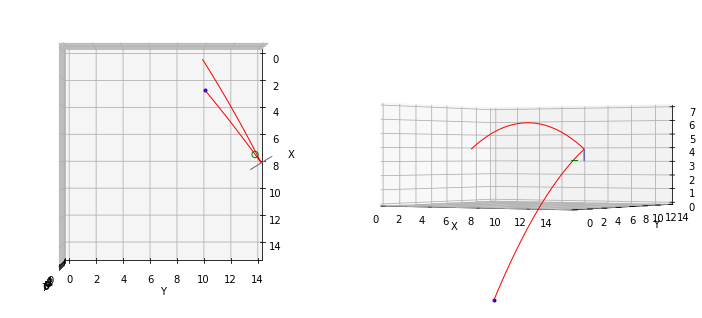

In [50]:
# Attaching 3D axis to the figure


print(f'xsp,ysp: {x_starting_point,y_starting_point}')
print(f'xbb,ybb: {Bb_x, Bb_y}')
fig = plt.figure(figsize=(20,10))

angle = calculated_z_rotation(Bb_x,Bb_y,BASKET_X,BASKET_Y,x_starting_point,y_starting_point)[0]
assert angle < 90, "Boundary error - keep rotation in [0:90["
print(f'angle: {np.rad2deg(angle)}')

## Calculating parametric coords of path 
t = time_2_basket(v0rand,horizontal_dist,z_theta)
xrnds, yrnds, zrnds = ball_path_3d(t,xy_theta,z_theta,x_starting_point,y_starting_point,z_starting_point,Bb_x,v0rand,angle)
xrnds=xrnds.reshape((len(xrnds),))
yrnds=yrnds.reshape((len(xrnds),))
zrnds=zrnds.reshape((len(xrnds),))



xmin, xmax = BACKBOARD_XMIN, BACKBOARD_XMAX
zmin, zmax = BACKBOARD_ZMIN, BACKBOARD_ZMAX
xx,zz      = np.meshgrid(np.linspace(xmin,xmax,2), np.linspace(zmin,zmax,2))
xx,yy      = rotate_backboard(angle/2,xx,[Bb_x, Bb_y]) ## ONLY ROTATING BACKBOARD HALF

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax.view_init(elev=90, azim=0)
ax2.view_init(elev=0, azim=np.rad2deg(angle/2))
x_ratio,y_ratio,z_ratio = COURT_WIDTH/(COURT_LENGTH*0.5) ,1, COURT_HEIGHT/(COURT_LENGTH*0.5)
ax.set_box_aspect((x_ratio,y_ratio,z_ratio)),ax2.set_box_aspect((x_ratio,y_ratio,z_ratio))
ax.set_xlim(0,COURT_WIDTH), ax.set_ylim(0,COURT_LENGTH/2), ax.set_zlim(0,COURT_HEIGHT)
ax2.set_xlim(0,COURT_WIDTH), ax2.set_ylim(0,COURT_LENGTH/2), ax2.set_zlim(0,COURT_HEIGHT)
ax.set_xlabel("X"),ax.set_ylabel("Y"),ax2.set_xlabel("X"),ax2.set_ylabel("Y")

## Plotting backboards
ax.plot_surface(xx, yy, zz, color="blue", linewidth=0.5, edgecolor="grey")
ax2.plot_surface(xx, yy, zz, color="blue", linewidth=0.5, edgecolor="grey")

# plotting rings
x0,y0 = COURT_WIDTH/2, COURT_LENGTH/2-(BASKET_DIAMETER/2+0.151)
p = Circle((x0,y0), BASKET_DIAMETER/2,fill=False,color="green")
ax.add_patch(p)
art3d.pathpatch_2d_to_3d(p, z=BASKET_HEIGHT, zdir="z")
x0,y0 = COURT_WIDTH/2, COURT_LENGTH/2-(BASKET_DIAMETER/2+0.151)
p = Circle((x0,y0), BASKET_DIAMETER/2,fill=False,color="green")
ax2.add_patch(p)
art3d.pathpatch_2d_to_3d(p, z=BASKET_HEIGHT, zdir="z")



Ball1, = ax.plot([],[],[],'bo',ms=3)
Line1, = ax.plot([],[],[],lw=1,color='red')
Ball2, = ax2.plot([],[],[],'bo',ms=3)
Line2, = ax2.plot([],[],[],lw=1,color='red')

def update_func(i):

    Line1.set_data(xrnds[:i+1], yrnds[:i+1])
    Line1.set_3d_properties(zrnds[:i+1])
    Ball1.set_data(xrnds[i], yrnds[i])
    Ball1.set_3d_properties(zrnds[i])

    Line2.set_data(xrnds[:i+1], yrnds[:i+1])
    Line2.set_3d_properties(zrnds[:i+1])
    Ball2.set_data(xrnds[i], yrnds[i])
    Ball2.set_3d_properties(zrnds[i])
    return Line1,Ball1,Line2,Ball2,
ani = animation.FuncAnimation(fig,func=update_func,frames = len(xrnds),blit = True,repeat=False,interval=1)
writervideo = animation.FFMpegWriter(fps=80) 
ani.save("Single_Basket_shot.mp4", dpi=150, writer=writervideo)   



Theta_i:[7.03397102]
Theta_c:62.11482817060318
Case 4
Theta_i:[16.2581777]
Theta_c:64.3432570741347
Case 1
Theta_i:[26.10783974]
Theta_c:28.454506716354935
Case 3
Theta_i:[12.06144377]
Theta_c:16.77377928875776
Case 3
Theta_i:[13.30130676]
Theta_c:63.753039086168464
Case 2


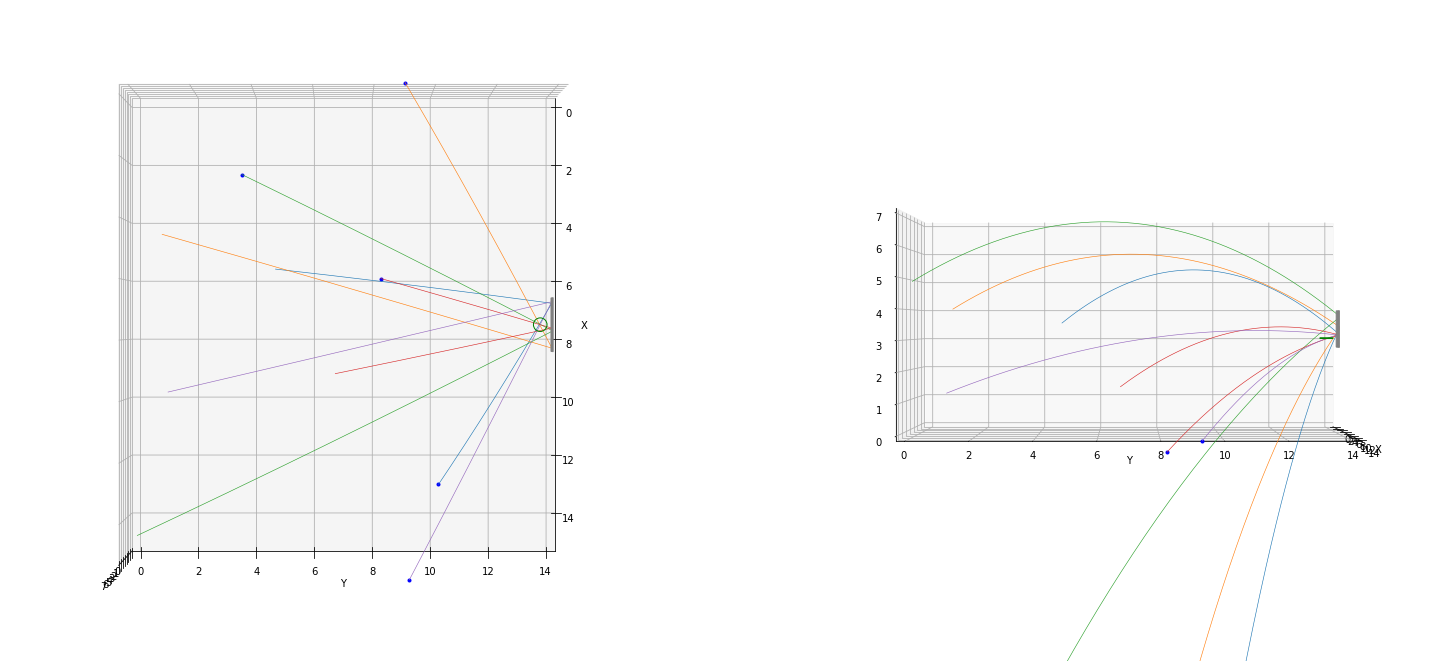

In [51]:
nr_shots = 5

xrndss, yrndss, zrndss = [], [], []
starting_points = []
for i in range(nr_shots):
    x_starting_point,y_starting_point,z_starting_point = random_starting_point()
    ## Approximate z range of basket backboard
    zmin, zmax = BACKBOARD_ZMIN, BACKBOARD_ZMAX
    ## Center location of basket backboard
    Basket_x, Basket_y = random_backboard_xy()
    ## Angle between direction in xy plane and x axis
    xy_theta = xy_angle(x_starting_point,y_starting_point,Basket_x,Basket_y)
    ## horizonal dist (in xy plane) from random point to backboard
    horizontal_dist = horizontal_dist_2_backboard(x_starting_point,y_starting_point,Basket_x,Basket_y)
    ## Random vertical angle
    z_theta  = random_angle(z_starting_point,horizontal_dist,zmax)
    ## Random speed  ( i.e.: ||v|| )
    v0rand = random_speed(z_theta,horizontal_dist,z_starting_point,zmax)
    ## Time to basket
    t = time_2_basket(v0rand,horizontal_dist,z_theta)
    ## Z-axis rotation of path 
    angle = calculated_z_rotation(Basket_x,Basket_y,BASKET_X,BASKET_Y,x_starting_point,y_starting_point)[0]
    ## Calculating parametric coords of path 
    xrnds, yrnds, zrnds = ball_path_3d(t,xy_theta,z_theta,x_starting_point,y_starting_point,z_starting_point,Basket_x,v0rand,angle)
    xrnds=xrnds.reshape((len(xrnds),))
    yrnds=yrnds.reshape((len(xrnds),))
    zrnds=zrnds.reshape((len(xrnds),))
    xrndss.append(xrnds),yrndss.append(yrnds),zrndss.append(zrnds)
    starting_points.append(np.array([x_starting_point,y_starting_point,z_starting_point]))



# Attaching 3D axis to the figure

fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Plotting backboards
x0,y0 = COURT_WIDTH/2-BACKBOARD_WIDTH/2, BASKET_HEIGHT-0.305
p = Rectangle((x0,y0), width = BACKBOARD_WIDTH, height = BACKBOARD_HEIGHT,color="grey")
ax.add_patch(p)
art3d.pathpatch_2d_to_3d(p, z=COURT_LENGTH/2, zdir="y")
x0,y0 = COURT_WIDTH/2-BACKBOARD_WIDTH/2, BASKET_HEIGHT-0.305
p = Rectangle((x0,y0), width = BACKBOARD_WIDTH, height = BACKBOARD_HEIGHT,color="grey")
ax2.add_patch(p)
art3d.pathpatch_2d_to_3d(p, z=COURT_LENGTH/2, zdir="y")

# plotting rings
x0,y0 = COURT_WIDTH/2, COURT_LENGTH/2-(BASKET_DIAMETER/2+0.151)
p = Circle((x0,y0), BASKET_DIAMETER/2,fill=False,color="green")
ax.add_patch(p)
art3d.pathpatch_2d_to_3d(p, z=BASKET_HEIGHT, zdir="z")
x0,y0 = COURT_WIDTH/2, COURT_LENGTH/2-(BASKET_DIAMETER/2+0.151)
p = Circle((x0,y0), BASKET_DIAMETER/2,fill=False,color="green")
ax2.add_patch(p)
art3d.pathpatch_2d_to_3d(p, z=BASKET_HEIGHT, zdir="z")


# Setting plot
ax.view_init(elev=90, azim=-0)
x_ratio,y_ratio,z_ratio = COURT_WIDTH/(COURT_LENGTH*0.5) ,1, COURT_HEIGHT/(COURT_LENGTH*0.5)
ax.set_box_aspect((x_ratio,y_ratio,z_ratio))
ax.set_xlim(0,COURT_WIDTH), ax.set_ylim(0,COURT_LENGTH*0.5), ax.set_zlim(0,COURT_HEIGHT)
ax.set_xlabel("X"), ax.set_ylabel("Y")
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax2.view_init(elev=0, azim=-0)
x_ratio,y_ratio,z_ratio = COURT_WIDTH/(COURT_LENGTH*0.5) ,1, COURT_HEIGHT/(COURT_LENGTH*0.5)
ax2.set_box_aspect((x_ratio,y_ratio,z_ratio))
ax2.set_xlim(0,COURT_WIDTH), ax2.set_ylim(0,COURT_LENGTH*0.5), ax2.set_zlim(0,COURT_HEIGHT)
ax2.set_xlabel("X"), ax2.set_ylabel("Y")
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=1)



Ball1s = [ax.plot([],[],[],'bo',ms=3)[0] for i in range(nr_shots)]
Ball2s = [ax2.plot([],[],[],'bo',ms=3)[0] for i in range(nr_shots)]
Line1s = [ax.plot([],[],[],lw=0.6)[0] for i in range(nr_shots)]
Line2s = [ax2.plot([],[],[],lw=0.6)[0] for i in range(nr_shots)]

def update_func(i):
    for idx,ball1 in enumerate(Ball1s):
        ball1.set_data(xrndss[idx][i], yrndss[idx][i])
        ball1.set_3d_properties(zrndss[idx][i])
    for idx,line1 in enumerate(Line1s):
        line1.set_data(xrndss[idx][:i+1], yrndss[idx][:i+1])
        line1.set_3d_properties(zrndss[idx][:i+1])
    for idx,ball2 in enumerate(Ball2s):
        ball2.set_data(xrndss[idx][i], yrndss[idx][i])
        ball2.set_3d_properties(zrndss[idx][i])
    for idx,line2 in enumerate(Line2s):
        line2.set_data(xrndss[idx][:i+1], yrndss[idx][:i+1])
        line2.set_3d_properties(zrndss[idx][:i+1])
    return [Ball1s[i] for i in range(len(Ball1s))]+[Ball2s[i] for i in range(len(Ball2s))]+[Line1s[i] for i in range(len(Line1s))]+[Line2s[i] for i in range(len(Line2s))]

ani = animation.FuncAnimation(fig,func=update_func,frames = len(xrnds),blit = True,repeat=False,interval=1)
writervideo = animation.FFMpegWriter(fps=60) 
ani.save("Multiple_Basket_shot.mp4", dpi=150, writer=writervideo)   
